In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from collections import deque

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

In [ ]:
# 🎯 Reward Logic
# Condition	Base Reward
# 🟢 Converted	+20
# 🟡 Responded only	+2
# 🔴 No response	-1
# ⚪️ No action taken	0

# Then we apply a fatigue penalty:
# final_reward = base_reward - (fatigue_count * fatigue_penalty)

In [ ]:
# -------------------------------
# Parameters
# -------------------------------
num_customers = 100
max_events_per_customer = 10

# Define campaigns and their base conversion rates
campaigns = {
    "Email Promo": 0.15,
    "SMS Offer": 0.20,
    "Call": 0.25,
    "No Action": 0.0
}

# Action to channel mapping
action_to_channel = {
    "Email Promo": "Email",
    "SMS Offer": "SMS",
    "Call": "Call",
    "No Action": "None"
}

# Fatigue and reward penalty
fatigue_penalty_per_repeat = 0.03
reward_penalty_per_fatigue = 0.5

In [ ]:
# -------------------------------
# Step 1: Generate Customer Profiles
# -------------------------------
locations = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai']
products = ['Credit Card', 'Loan', 'Savings Account', 'Insurance']

profile_data = []
for i in range(num_customers):
    profile_data.append({
        "customer_id": f"C{i:03d}",
        "age": random.randint(22, 60),
        "gender": random.choice(['M', 'F']),
        "location": random.choice(locations),
        "salary": random.randint(30000, 150000),
        "product_owned": random.choice(products)
    })

df_profiles = pd.DataFrame(profile_data)
df_profiles.to_csv("customer_profiles.csv", index=False)

# -------------------------------
# Step 2: Create Campaign Metadata
# -------------------------------
df_campaigns = pd.DataFrame([
    {"action_name": k, "base_conversion_rate": v} for k, v in campaigns.items()
])
df_campaigns.to_csv("campaign_metadata.csv", index=False)

# -------------------------------
# Step 3: Define Reward Function
# -------------------------------
def compute_reward(responded, converted, fatigue_count, action_taken):
    if action_taken == "No Action":
        return 0.0
    if converted:
        base = 20.0  # High reward for conversion
    elif responded:
        base = 2.0
    else:
        base = -1.0
    penalty = fatigue_count * reward_penalty_per_fatigue
    return max(base - penalty, -5.0)

# -------------------------------
# Step 4: Generate Customer Events
# -------------------------------
event_types = ['click', 'visit', 'purchase', 'login']
all_events = []

for customer in df_profiles['customer_id']:
    fatigue_counter = {action: 0 for action in campaigns}
    channel_fatigue = {"Email": 0, "SMS": 0, "Call": 0, "None": 0}
    
    start_time = datetime(2023, 6, 1)
    last_time = start_time

    for step in range(max_events_per_customer):
        action = random.choices(list(campaigns.keys()), weights=[0.4, 0.3, 0.2, 0.1])[0]
        base_rate = campaigns[action]
        fatigue = fatigue_counter[action]
        adjusted_rate = max(base_rate - fatigue_penalty_per_repeat * fatigue, 0.01)

        responded = 1 if random.random() < adjusted_rate + 0.1 else 0
        converted = 1 if random.random() < adjusted_rate else 0

        # Time handling
        if step == 0:
            gap_days = 0
            event_time = start_time
        else:
            gap_days = random.randint(1, 5)
            event_time = last_time + timedelta(days=gap_days)
        last_time = event_time

        # Other event data
        event_type = random.choice(event_types)
        amount = random.randint(100, 2000) if event_type == 'purchase' else 0

        reward = compute_reward(responded, converted, fatigue, action)
        channel = action_to_channel[action]

        all_events.append({
            "customer_id": customer,
            "timestamp": event_time.strftime('%Y-%m-%d %H:%M:%S'),
            "event_type": event_type,
            "amount": amount,
            "action_taken": action,
            "channel": channel,
            "responded": responded,
            "converted": converted,
            "fatigue_count": fatigue,
            "gap_days": gap_days,
            "reward": round(reward, 2)
        })

        # Update fatigue trackers
        fatigue_counter[action] += 1
        channel_fatigue[channel] += 1

        if converted == 1:
            break  # Stop on conversion

# Save all events
df_events = pd.DataFrame(all_events)
# df_events.to_csv("customer_events.csv", index=False)

print("✅ Synthetic data generated with channel info and reward logic.")

In [ ]:
print (df_events.shape)
print (df_events["customer_id"].nunique())
df_events.head(100)

In [ ]:
print (df_profiles.shape)
print (df_profiles["customer_id"].nunique())
df_profiles.head()

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# Load data
events = pd.read_csv("customer_events.csv")
profiles = pd.read_csv("customer_profiles.csv")

# Merge
data = events.merge(profiles, on="customer_id", how="left")

# Encode categorical columns
encoders = {}
for col in ['event_type', 'action_taken', 'channel', 'gender', 'location', 'product_owned']:
    le = LabelEncoder()
    data[col + '_id'] = le.fit_transform(data[col])
    encoders[col] = le

In [12]:
events.head()

,customer_id,timestamp,event_type,amount,action_taken,channel,responded,converted,fatigue_count,gap_days,reward
0,C000,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
1,C000,2023-06-06 00:00:00,purchase,1067,SMS Offer,SMS,1,0,0,5,2.0
2,C000,2023-06-11 00:00:00,click,0,SMS Offer,SMS,0,1,1,5,19.5
3,C001,2023-06-01 00:00:00,click,0,Email Promo,Email,0,0,0,0,-1.0
4,C001,2023-06-04 00:00:00,visit,0,Call,Call,0,0,0,3,-1.0


In [14]:
encoders

{'event_type': LabelEncoder(),
 'action_taken': LabelEncoder(),
 'channel': LabelEncoder(),
 'gender': LabelEncoder(),
 'location': LabelEncoder(),
 'product_owned': LabelEncoder()}

In [3]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import clone_model
import matplotlib.pyplot as plt

# --------------------------
# 🏗️ Environment Definition
# --------------------------
class MarketingEnv:
    def __init__(self, campaigns, base_conversion, fatigue_penalty=0.03):
        self.campaigns = campaigns
        self.base_conversion = base_conversion
        self.fatigue_penalty = fatigue_penalty
        self.reset()

    def reset(self):
        """Initialize new episode (customer)"""
        self.state = {
            "gap_days": 0,
            "fatigue": {a: 0 for a in self.campaigns},  #{'Email Promo': 0, 'SMS Offer': 0, 'Call': 0, 'No Action': 0}
            "responded": 0,
            "converted": 0
        }
        self.steps = 0
        return self._get_state_vector()

    def _get_state_vector(self):
        """Convert dictionary to numeric state vector"""
        gap = self.state["gap_days"]
        fatigue_vals = np.array(list(self.state["fatigue"].values()))
        fatigue_mean = np.mean(fatigue_vals)
        responded = self.state["responded"]
        converted = self.state["converted"]
        return np.array([gap, fatigue_mean, responded, converted], dtype=np.float32)

    def step(self, action_name):
        """Take an action and evolve the environment"""
        base_prob = self.base_conversion[action_name]
        fatigue_count = self.state["fatigue"][action_name]
        adjusted_rate = max(base_prob - fatigue_count * self.fatigue_penalty, 0.01)

        responded = 1 if random.random() < adjusted_rate + 0.1 else 0
        converted = 1 if random.random() < adjusted_rate else 0

        # compute reward
        if converted:
            reward = 20.0
        elif responded:
            reward = 2.0
        else:
            reward = -1.0

        # update environment
        for a in self.state["fatigue"]:
            self.state["fatigue"][a] += 1 if a == action_name else 0

        self.state["gap_days"] = random.randint(1, 5)
        self.state["responded"] = responded
        self.state["converted"] = converted
        self.steps += 1

        done = converted or self.steps >= 10
        return self._get_state_vector(), reward, done

In [26]:

state = {
    "gap_days": 0,
    "fatigue": {a: 0 for a in campaigns},  #{'Email Promo': 0, 'SMS Offer': 0, 'Call': 0, 'No Action': 0}
    "responded": 0,
    "converted": 0
}
state["fatigue"].values()

dict_values([0, 0, 0, 0])

NameError: name '_get_state_vector' is not defined

In [4]:
# Transformer Q-Network

# (Using your 6-feature sequence + static profile)

In [5]:
def transformer_block(x, ff_dim, num_heads):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = LayerNormalization()(x + attn_output)
    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    return LayerNormalization()(x + ffn_output)

def build_q_model(seq_len, seq_feat_dim, profile_dim, num_actions,
                  embed_dim=64, ff_dim=128, num_heads=4):
    seq_input = Input(shape=(seq_len, seq_feat_dim))
    x = Dense(embed_dim, activation="relu")(seq_input)
    x = transformer_block(x, ff_dim, num_heads)
    x = GlobalAveragePooling1D()(x)

    profile_input = Input(shape=(profile_dim,))
    p = Dense(embed_dim, activation="relu")(profile_input)

    merged = Concatenate()([x, p])
    merged = Dense(128, activation="relu")(merged)
    merged = Dropout(0.2)(merged)
    q_values = Dense(num_actions, activation="linear")(merged)

    model = Model([seq_input, profile_input], q_values)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    return model

In [15]:
{a: 0 for a in campaigns}

{'Email Promo': 0, 'SMS Offer': 0, 'Call': 0, 'No Action': 0}

In [7]:
campaigns = ["Email Promo", "SMS Offer", "Call", "No Action"]
base_conversion = {"Email Promo": 0.15, "SMS Offer": 0.2, "Call": 0.25, "No Action": 0.0}

env = MarketingEnv(campaigns, base_conversion)
num_actions = len(campaigns)
state_dim = 4     # gap, avg fatigue, responded, converted
profile_dim = 5   # static profile features (optional synthetic vector)
seq_len = 10

model = build_q_model(seq_len, state_dim, profile_dim, num_actions)
target_model = clone_model(model)
target_model.set_weights(model.get_weights())

gamma = 0.95
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
batch_size = 32
train_episodes = 20
update_target_every = 10
replay_buffer = deque(maxlen=5000)

reward_log, loss_log = [], []

for ep in range(train_episodes):
    state = np.zeros((seq_len, state_dim))
    profile = np.random.rand(1, profile_dim).astype(np.float32)
    env_state = env.reset()
    total_reward = 0

    for t in range(seq_len):
        state[t] = env_state

        # ε-greedy
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(num_actions)
        else:
            q_vals = model.predict([state[np.newaxis], profile], verbose=0)
            action_idx = np.argmax(q_vals[0])

        next_state_vec, reward, done = env.step(campaigns[action_idx])
        total_reward += reward

        next_state = np.roll(state, -1, axis=0)
        next_state[-1] = next_state_vec

        replay_buffer.append((state.copy(), profile.copy(), action_idx, reward, next_state.copy(), done))
        env_state = next_state_vec
        state = next_state

        if done:
            break

        # Training
        if len(replay_buffer) > batch_size:
            minibatch = random.sample(replay_buffer, batch_size)
            state_mb = np.array([m[0] for m in minibatch])
            profile_mb = np.array([m[1][0] for m in minibatch])
            action_mb = np.array([m[2] for m in minibatch])
            reward_mb = np.array([m[3] for m in minibatch])
            next_state_mb = np.array([m[4] for m in minibatch])
            done_mb = np.array([m[5] for m in minibatch])

            q_pred = model.predict([state_mb, profile_mb], verbose=0)
            q_next = target_model.predict([next_state_mb, profile_mb], verbose=0)

            for i in range(batch_size):
                q_pred[i, action_mb[i]] = reward_mb[i] if done_mb[i] else reward_mb[i] + gamma * np.max(q_next[i])

            loss = model.train_on_batch([state_mb, profile_mb], q_pred)
            loss_log.append(loss)

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    if ep % update_target_every == 0:
        target_model.set_weights(model.get_weights())

    reward_log.append(total_reward)
    print(f"Episode {ep+1}/{train_episodes} | Reward: {total_reward:.1f} | Epsilon: {epsilon:.3f}")

Episode 1/20 | Reward: 18.0 | Epsilon: 0.995
Episode 2/20 | Reward: 23.0 | Epsilon: 0.990
Episode 3/20 | Reward: 19.0 | Epsilon: 0.985
Episode 4/20 | Reward: 22.0 | Epsilon: 0.980
Episode 5/20 | Reward: 20.0 | Epsilon: 0.975
Episode 6/20 | Reward: 23.0 | Epsilon: 0.970
Episode 7/20 | Reward: 17.0 | Epsilon: 0.966
Episode 8/20 | Reward: 15.0 | Epsilon: 0.961
Episode 9/20 | Reward: 17.0 | Epsilon: 0.956
Episode 10/20 | Reward: 2.0 | Epsilon: 0.951
Episode 11/20 | Reward: 21.0 | Epsilon: 0.946
Episode 12/20 | Reward: -1.0 | Epsilon: 0.942
Episode 13/20 | Reward: -4.0 | Epsilon: 0.937
Episode 14/20 | Reward: 15.0 | Epsilon: 0.932
Episode 15/20 | Reward: 20.0 | Epsilon: 0.928
Episode 16/20 | Reward: 18.0 | Epsilon: 0.923
Episode 17/20 | Reward: 19.0 | Epsilon: 0.918
Episode 18/20 | Reward: 16.0 | Epsilon: 0.914
Episode 19/20 | Reward: 16.0 | Epsilon: 0.909
Episode 20/20 | Reward: -7.0 | Epsilon: 0.905


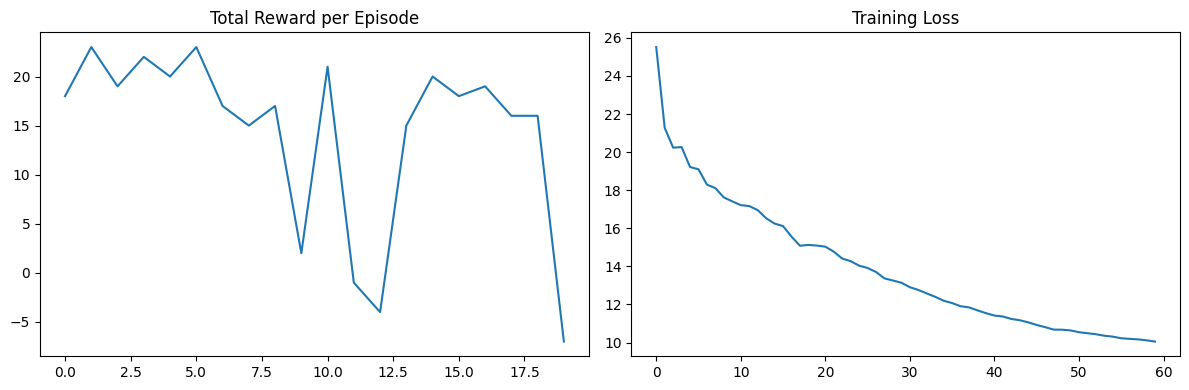

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(reward_log)
plt.title("Total Reward per Episode")

plt.subplot(1,2,2)
plt.plot(loss_log)
plt.title("Training Loss")
plt.tight_layout()
plt.show()

In [9]:
# ✅ Explanation
# Component	Purpose
# MarketingEnv	Simulates how a customer responds to campaigns dynamically
# step()	Updates gap, fatigue, responded, and conversion
# reset()	Starts a new customer episode
# reward	+20 for conversion, +2 for response, -1 otherwise
# done	Ends episode when conversion happens or after 10 steps
# epsilon-greedy	Balances exploration/exploitation
# target network	Stabilizes training
# experience replay	Samples past experiences for learning stability

In [11]:
# --------------------------
# 🔮 Prediction for New Data
# --------------------------

# Example new customer's static profile
# Format: [age, gender_id, salary, location_id, product_owned_id]
new_profile = np.array([[35, 1, 60000, 2, 0]], dtype=np.float32)

# Example of their latest 10-step sequence (or fewer if you have shorter)
# Format per step: [gap_days, avg_fatigue, responded, converted]
new_sequence = np.array([
    [1, 0.1, 0, 0],
    [2, 0.2, 1, 0],
    [3, 0.3, 1, 0],
    [4, 0.3, 0, 0],
    [5, 0.4, 0, 0],
    [0, 0.0, 0, 0],
    [0, 0.0, 0, 0],
    [0, 0.0, 0, 0],
    [0, 0.0, 0, 0],
    [0, 0.0, 0, 0]
], dtype=np.float32)

# Add batch dimension
new_sequence = np.expand_dims(new_sequence, axis=0)

# Predict Q-values for each possible action
pred_q = model.predict([new_sequence, new_profile], verbose=0)
best_action_idx = np.argmax(pred_q[0])
best_action = campaigns[best_action_idx]

print("🧠 Predicted Q-values:", pred_q[0])
print("✅ Recommended next action:", best_action)

🧠 Predicted Q-values: [19089.01   37813.926  -1818.4604 28726.727 ]
✅ Recommended next action: SMS Offer
